# STDP spiking classifier for somatosensory data

Increasing width of notebook, (not important, just preference)

In [38]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

## brian2 installation!

In [3]:
!python -m pip install brian2
!python -m pip install brian2tools

## Import statements

In [5]:
import numpy as np
import matplotlib.cm as cmap
import time
import os.path
import scipy 
import pickle
import brian2 as b
from struct import unpack
from brian2 import *
from brian2tools import *

## Functions

In [53]:
def get_labeled_touch_vec_data(first_file_num, last_file_num, data_path):
    
    N = last_file_num - (first_file_num - 1)
    tot_N = N * 26
    x = np.zeros((tot_N, 5))
    y = np.zeros((tot_N, 1))
    
    pos = 0
    for file_num in range(first_file_num, last_file_num+1):
        file_name = 'Training' + str(file_num) + '.txt'
        file_path = data_path + file_name
        touch_vecs = open(file_path)
        for letter in range(26):
            y[letter + pos] = (ord(touch_vecs.read(1)) - 65)
            
            touch_vecs.read(1)
        x[pos:(pos+26), :] = np.transpose(np.loadtxt(file_path, skiprows=1))
        
        pos += 26
    data = {'data': x, 'label': y}
    return data


def plot_2d_input_weights(fig_num):
    weights = get_2d_input_weights()
    fig = plt.figure(fig_num, figsize = (18, 18))
    im2 = plt.imshow(weights, interpolation = "nearest", vmin = 0, vmax = wmax_ee, cmap = cmap.get_cmap('hot_r'))
    plt.colorbar(im2)
    plt.title('weights of input connection')
    fig.canvas.draw()
    return (fig_num + 1), im2, fig








### All this probably won't work because the input_dim is not sqrtable, oh well figure that out later
def get_2d_input_weights():
    weight_matrix = np.zeros((input_dim, n_e))
    n_e_sqrt = int(np.sqrt(n_e))
    n_in_sqrt = int(np.sqrt(input_dim))
    num_values_col = n_e_sqrt*n_in_sqrt
    num_values_row = num_values_col
    rearranged_weights = np.zeros((num_values_col, num_values_row))
    connMatrix = np.zeros((input_dim, n_e))
    connMatrix[input_synapses.i, input_synapses.j] = input_synapses.w
    weight_matrix = np.copy(connMatrix)

    for i in xrange(n_e_sqrt):
        for j in xrange(n_e_sqrt):
                rearranged_weights[i*n_in_sqrt : (i+1)*n_in_sqrt, j*n_in_sqrt : (j+1)*n_in_sqrt] = \
                    weight_matrix[:, i + j*n_e_sqrt].reshape((n_in_sqrt, n_in_sqrt))
    return rearranged_weights


# Will probs use the connection list name system so here is a fun from [1]
def normalize_weights():
    for connName in connections:
        if connName[1] == 'e' and connName[3] == 'e':
            connection = connections[connName][:]
            temp_conn = np.copy(connection)
            colSums = np.sum(temp_conn, axis = 0)
            colFactors = weight['ee_input']/colSums
            for j in range(n_e):#
                connection[:,j] *= colFactors[j]
                


## Loading data into np arrays

In [54]:
# specify the location of the data
notebook_path = os.path.abspath("BRIAN_DIEHL_COOK_2015.ipynb")
touch_data_vec_path = os.path.join(os.path.dirname(notebook_path), "Datasets\\Vector-data-of-A-Z\\")

start = time.time()
training = get_labeled_touch_vec_data(1,19,touch_data_vec_path)
end = time.time()
#print('time needed to load training set:', end - start)
 
start = time.time()
testing = get_labeled_touch_vec_data(20,20,touch_data_vec_path)
end = time.time()
#print('time needed to load test set:', end - start)


## Setting parameters and equations for neuronal behaviour

In [55]:
# For using numpy directly for simulation instead of C++ codegen
prefs.codegen.target = 'numpy'

input_dim = 5
epoch_num = 100 #100 chosen to be in a similar order of magnitude as the number of training samples used in [1] (3 epochs (passes) of 60000 sized MNIST data)
sample_count = (26 * 19) * epoch_num #(26 letters per trial, 19 trials)
n_e = 400 # excitatory neuron count in [1]: 400
n_i = n_e
input_sample_time = 350*ms
inter_input_time = 150*ms
sample_time = (input_sample_time + inter_input_time)
full_runtime = sample_time * sample_count


# These values just taken from [1]
v_rest_e = -65. * mV 
v_rest_i = -60. * mV 
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms

# [1] also had these values, not sure what they're used for @29.6.2023
update_interval = 100 #was 10000 in [1]
weight_update_interval = 26 #


weight = {}
delay = {}
weight['ee_input'] = 78. # I'll see how I do it, but in the original implementation I understood that this value keeps the column sum of weights nigh 78 via the 
                         # normalize_weights() function
delay['ee_input'] = (0*ms,10*ms) 
delay['ei_input'] = (0*ms,5*ms) #This one isn't used currently

input_intensity = 64. #maximum Hz of input


tc_pre_ee = 20*ms
tc_post_1_ee = 20*ms
tc_post_2_ee = 40*ms
nu_ee_pre =  0.0001      # Change in weight w/ learning
nu_ee_post = 0.01        # Change in weight w/ learning
wmax_ee = 1.0
exp_ee_pre = 0.2
exp_ee_post = exp_ee_pre
STDP_offset = 0.4 

## Reset stuff
theta_plus_e = 0.05 * mV
e_reset_str = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
i_reset_str = 'v=v_reset_i'

## threshold voltages
offset = 20.*mV
e_thresh_str = '(v>(theta - offset + v_thresh_e )) and (timer>refrac_e)' # I don't recall the raison d'etre of offset in the architecture
i_thresh_str = 'v>v_thresh_i'


#Equations for processing neural layers
tc_theta = 1e7 * ms #time constant for theta
eqs_e = '''
        dv/dt = ((v_rest_e - v) + (I_synE+I_synI) / nS) / (100*ms)  : volt (unless refractory)
        I_synE = ge * nS *         -v                               : amp
        I_synI = gi * nS * (-100.*mV-v)                             : amp
        dge/dt = -ge/(1.0*ms)                                       : 1
        dgi/dt = -gi/(2.0*ms)                                       : 1
        dtheta/dt = -theta / (tc_theta)  : volt
        dtimer/dt = 0.1  : second
        '''

eqs_i = '''
        dv/dt = ((v_rest_i - v) + (I_synE+I_synI) / nS) / (10*ms)  : volt (unless refractory)
        I_synE = ge * nS *         -v                              : amp
        I_synI = gi * nS * (-85.*mV-v)                             : amp
        dge/dt = -ge/(1.0*ms)                                      : 1
        dgi/dt = -gi/(2.0*ms)                                      : 1
        '''


#For excitatory to excitatory connection, in this case from input to excitatory neurons
eqs_stdp_ee = '''
                post2before                            : 1
                dpre/dt   =  -pre/(tc_pre_ee)         : 1 (event-driven)
                dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
                dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
            '''
eqs_stdp_pre_ee = 'pre = 1.; w = clip(w + nu_ee_pre * post1, 0, wmax_ee)'
eqs_stdp_post_ee = 'post2before = post2; w = clip(w + nu_ee_post * pre * post2before, 0, wmax_ee); post1 = 1.; post2 = 1.'



plt.ion() # Interactive mode on
fig_num = 1 #?
result_monitor = np.zeros((update_interval,n_e))



## Creation of network objects

In [56]:
#Create neuron groups
e_neurons = NeuronGroup(n_e, eqs_e, threshold= e_thresh_str, refractory= refrac_e, reset= e_reset_str, method='euler')
i_neurons = NeuronGroup(n_i, eqs_i, threshold= i_thresh_str, refractory= refrac_i, reset= i_reset_str, method='euler')

#set start voltages
e_neurons.v = v_rest_e - 40*mV
i_neurons.v = v_rest_e - 40*mV

#set theta values
e_neurons.theta = np.ones((n_e)) * 20.*mV

## Create connections between the excitatory and inhibitory neurons
# First excitatory to inhibitory synapses
e_weightMatrix = np.random.rand(n_e, n_i)
model = 'w : 1'
pre = 'ge_post += w'
post = ''

ei_synapses = Synapses(e_neurons, i_neurons, model=model, on_pre=pre, on_post=post)
ei_synapses.connect(True) #Creates all-to-all connection
ei_synapses.w = e_weightMatrix[ei_synapses.i, ei_synapses.j] #.i and .j refer to the pre and post neuron in the synapse


# inhibitory to excitatory synapses
pre = 'gi_post += w'
i_weightMatrix = np.random.rand(n_e, n_i)

ie_synapses = Synapses(i_neurons, e_neurons, model=model, on_pre=pre, on_post=post)
ie_synapses.connect(True) #Creates all-to-all connection
ie_synapses.w = i_weightMatrix[ei_synapses.i, ei_synapses.j] #.i and .j refer to the pre and post neuron in the synapse


### The creation of Poisson inputs from vec data
input_weightMatrix = np.random.rand(input_dim, n_e) #initially random weights
input_neurons = PoissonGroup(5, 0*Hz)


# creation of synapse from input to excitatory
model = 'w : 1' + eqs_stdp_ee
pre = 'ge_post += w; ' + eqs_stdp_pre_ee
post = eqs_stdp_post_ee

input_synapses = Synapses(input_neurons, e_neurons, model=model, on_pre=pre, on_post=post)

min_delay = delay['ee_input'][0]
max_delay = delay['ee_input'][1]
delta_delay = max_delay - min_delay
# TODO: test this ## That was note from brian2 translator, I wonder why, hmm

input_synapses.connect(True) # all-to-all connection
input_synapses.delay = 'min_delay + rand() * delta_delay'
input_synapses.w = input_weightMatrix[input_synapses.i, input_synapses.j]


### Creation of monitors
e_rate_monitor = PopulationRateMonitor(e_neurons)
i_rate_monitor = PopulationRateMonitor(i_neurons)
e_spike_monitor = SpikeMonitor(e_neurons)
i_spike_monitor = SpikeMonitor(i_neurons)
input_rate_monitor = PopulationRateMonitor(input_neurons)

## Running the simulation

In [50]:
previous_spike_count = np.zeros(n_e)
assignments = np.zeros(n_e)
input_numbers = [0] * sample_count
outputNumbers = np.zeros((sample_count, 10))

for j in range(sample_count):
    spike_rates = training['data'][j%(19*26),:] *  input_intensity
    input_neurons.rates = spike_rates * Hz
    
    normalize_weights()
    run(sample_time, report='text')


# Unimportant plotting (a lot more where that came from)
# fig_num, input_weight_fig, fig_weights = plot_2d_input_weights(fig_num)

# this thing is in the original code before the loop, no idea why 
# for i,name in enumerate(input_population_names):
#     input_groups[name+'e'].rates = 0 * Hz
# net.run(0*second)



KeyError: 'data'

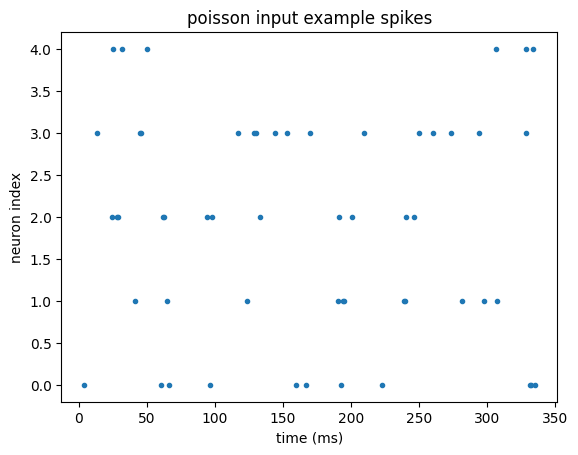

In [35]:
# plotting stuff
# example spiking for one input
brian_plot(input_monitor).set_title('poisson input example spikes');

address these questions:

- Raison d'etre of offset in the architecture
- STDP_offset does what exactly
- check what exactly True means as a parameter in ```Synapses().connect(True)```
- is the fig_num parameter doing anything







Random thoughts:
- Connect multiple modalities of inputs to each other. That sounds really good and something that can be done pretty soon after I get this done